#### pandas 2

1. Please read in the data contained in the file `fxcm_eur_usd_eod_data.csv` that you can find in the `data` folder of the course materials. Make a plot showing the time series of the daily BidClose, AskClose, BidLow, and AskHigh prices.

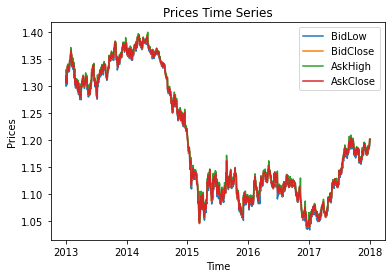

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

#We start by loading the csv file into the python environment
#file = 'C:/Users/Christian Lindquist/Downloads/Uni Wien Materials/Python for Finance 1/course materials/fxcm_eur_usd_eod_data.csv'
table = pd.read_csv('fxcm_eur_usd_eod_data.csv', index_col= [0], parse_dates = [0]) #index column is column 0, which contains the respective dates

plt.plot(table.BidLow, label = 'BidLow') #Plot the BidLow column of the created DataFrame
plt.plot(table.BidClose, label = 'BidClose') #Plot the BidClose column of the created DataFrame
plt.plot(table.AskHigh, label = 'AskHigh') #Plot the AskHigh column of the created DataFrame
plt.plot(table.AskClose, label = 'AskClose') #Plot the AskClose column of the created DataFrame
plt.title('Prices Time Series')
plt.legend()
plt.ylabel('Prices')
plt.xlabel('Time')
plt.show()
#table


#real_timeseries = pd.date_range('2013-01-01','2017-12-31', freq ="D") #Index for new and complete timeframe (as in original data many days are missing)
#real_table = table.reindex(real_timeseries, method = "bfill") #we create new complete DataFrame using Backward fill for missing days from original Dataframe
#print(real_table)
#We plot the new complete DataFrame for comparison with the provided incomplete DataFrame
# plt.plot(real_table.BidLow, label = 'BidLow') #Plot the BidLow column of the self created table
# plt.plot(real_table.BidClose, label = 'BidClose') #Plot the BidClose column of the self created table
# plt.plot(real_table.AskHigh, label = 'AskHigh') #Plot the AskHigh column of the self created table
# plt.plot(real_table.AskClose, label = 'AskClose') #Plot the AskClose column of the self created table
# plt.title('Time Series') 
# plt.legend()
# plt.ylabel('Prices')
# plt.xlabel('Time')
# plt.show() #Show the plot

2. Change the frequency of the data from daily to weekly. Open prices should be the open on the first day of the week, close prices those on the last day, and highs and lows the highest and lowest values observed during the week. Make a plot showing the time series of the weekly BidClose, AskClose, BidLow, and AskHigh prices.

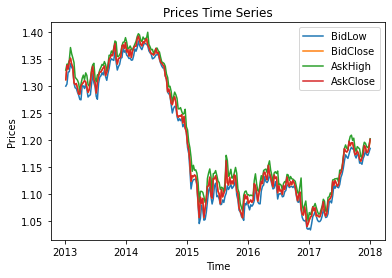

In [2]:
week = pd.DataFrame()

table_week = table.resample("W").ohlc() #We decrease DataFrame frequency with "Resample" from daily to weekly
#With ".ohlc()" we get for every column of our original DataFrame the open, high, low and close price adapted to the new (decreased) frequency

#In the following we pick out the relevant columns (for BidOpen and AskOpen prices we want the Open prices of the week and discard the High, Low and Close prices for example)
week = table_week.loc[:, [['BidOpen','open'],['BidHigh','high'],['BidLow','low'],['BidClose','close'],['AskOpen','open'],['AskHigh','high'],['AskLow','low'],['AskClose','close']]] 
week.columns = ['BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose'] #renaming the columns to a one level index
#print(week)

plt.plot(week.BidLow, label ='BidLow') #Plot the BidLow column of the created weekly DataFrame
plt.plot(week.BidClose, label ='BidClose') #Plot the BidClose column of the created weekly DataFrame
plt.plot(week.AskHigh, label ='AskHigh') #Plot the AskHigh column of the created weekly DataFrame
plt.plot(week.AskClose, label ='AskClose') #Plot the AskClose column of the created weekly DataFrame
plt.title('Prices Time Series')
plt.legend()
plt.ylabel('Prices')
plt.xlabel('Time')
plt.show() #Show the PLot


3. Suppose that you value your portfolio in euros and that you start with a position of 100 euros and 0 dollars. Consider a "flight to safety" strategy that invests in the dollar in volatile times and holds the euro in calm times. To be able to implement such a strategy, you first need to determine whether the volatility is relatively high or low. Define volatility as the difference between weekly AskHigh and BidLow divided by the average of BidOpen and AskOpen. Compute the historical average volatility using an expanding window, i.e., compute the mean volatility only based on data observed before the current week (look up `expanding` in the pandas documentation). Make a plot showing the time series of the weekly volatility and the historical average volatility.

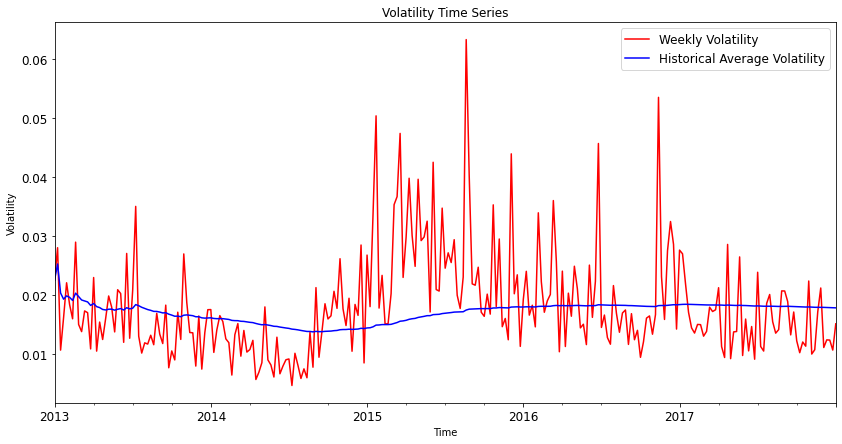

In [3]:
#Volatility = (weekly AskHigh - weekly BidLow) / ((BidOpen + AskOpen)/2)
week['vol'] = (week['AskHigh'] - week['BidLow']) / ((week['BidOpen'] + week['AskOpen']) /2) #We create a new column with the respective weekly volatility

#In the following we calculate the average historical volatility
mean_data = week.expanding(1).mean() #we calculate the expanding average historical mean for all € in $ prices, with min nr of periods = 1, as we want to start form the first week
mean_data['vol'] = (mean_data['AskHigh'] - mean_data['BidLow']) / ((mean_data['BidOpen'] + mean_data['AskOpen']) /2) #We calculate the historical average volatility with the historical average prices

#To plot the results we merge the two columns of interest into on DataFrame
plot_data = pd.DataFrame.merge(week['vol'],mean_data['vol'], left_index=True, right_index=True)
plot_data.columns = ['Weekly Volatility','Historical Average Volatility'] #We rename the columns
#print(plot_data)

plot_data.plot(color = ['r','b'], figsize = (14,7), fontsize = 12) #We plot the first column in red and the second one in blue
plt.title('Volatility Time Series')
plt.legend(plot_data.columns, fontsize = 12)
plt.ylabel('Volatility')
plt.xlabel('Time')
plt.show()


# mean_data = pd.DataFrame()
# for i in enumerate(week.index):
#     a = week.expanding(i[0]+1).mean()
#     #print(a)
#     mean_data = mean_data.append(a.iloc[i[0]])

4. Assume that if you buy the euro (against the dollar), you will need to buy at the ask, and if you sell, this will happen at the bid. Compute the returns of the flight to safety strategy (i) based on the unrealistic assumption that you know the upcoming week's volatility at the end of the previous week, (ii) based on the more realistic assumption that you take a position based on the previous week's volatility. Additionally, consider a strategy (iii) holding a long position in the dollar for the whole sample period. 
Compute each strategy's average weekly return and standard deviation of weekly returns. 

In [4]:
# We assume a week is volatile if weekly volatility is higher than the historical volatility for that week. 
# If weekly vol is smaller than the historical vol we assume it to be a calm week

# To apply the strategies we insert the average weekly volatilities in the weekly prices DataFrame
week['average vol'] = mean_data['vol']

#Strategy i)#############################################################################################################
week_strategy_i = week.copy() #we use a copy of the "week" DataFrame to not accidentally change any of the data
def r_strategy_i(week):
    week['budget'] = 100 #create a budget column
    week['currency'] = 'EUR' #define the currency of the budget 

    for i in enumerate(week.index): #We go through every week
            if week.iat[i[0],8] > week.iat[i[0],9]: #volatile week?
                if week.iat[i[0]-1,8] <= week.iat[i[0]-1,9]: #if previous week "different strategy" (calm)
                    week.iat[i[0],10] = week.iat[i[0]-1,10] * week.iat[i[0],0] #budget of previous week in € is changed into $ this week (through BidOpen), as we make a decision before the week happens
                    week.iat[i[0],11] = 'USD' #new currency is $
                else:
                    week.iat[i[0],10] = week.iat[i[0]-1,10] #if previous week follows same high volatility strategy as this week we just keep the previous budget amount
                    week.iat[i[0],11] = 'USD' #in volatile weeks we keep the dollar
            elif week.iat[i[0],8] <= week.iat[i[0],9]: #calm week?
                if week.iat[i[0]-1,8] > week.iat[i[0]-1,9]: #if previous week "different strategy" (volatile)
                    week.iat[i[0],10] = week.iat[i[0]-1,10] / week.iat[i[0],4] #budget of previous week in $ is changed into € this week (through AskOpen), as we make a decision before the week happens
                    week.iat[i[0],11] = 'EUR' #new currency is €
                else:
                    week.iat[i[0],10] = week.iat[i[0]-1,10] #if previous week follows same low volatility strategy as this week we just keep the previous budget amount
                    week.iat[i[0],11] = 'EUR' #in calm weeks we keep the euro

    # showing the budget in EUR only. if the currency is USD, we sell USD at AskOpen price
    week['budget_in_euro'] = week.apply(lambda row: row['budget'] if row['currency'] == 'EUR' else row['budget'] / row['AskOpen'], 1)
    # In the following we calculate the strategy returns
    week['weekly_returns'] = 0
    for i in enumerate(week.index,1): #we start from the second week, return in week 1 being = 0
        if i[0] == 261:
            break
        week.iat[i[0],13] = (week.iat[i[0],12] - week.iat[i[0]-1,12])/week.iat[i[0]-1,12] #we define weekly return = (present week budget - previous week budget) / previous week budget
    print("The Mean of the Weekly Returns of Strategy i amounts to:", week.weekly_returns.mean()*100,"%")
    print("The Standard Deviation of the Weekly Returns of Strategy i amounts to:", week.weekly_returns.std()*100,"%")

r_strategy_i(week_strategy_i) #we run the function with the DataFrame copy

#Strategy ii)##########################################################################################################################
week_strategy_ii = week.copy() #we use a copy of the "week" DataFrame to not accidentally change any of the data
def r_strategy_ii(week):
    week['budget'] = 100 #create a budget column
    week['currency'] = 'EUR' #define the currency of the budget

    for i in enumerate(week.index): #We go through every week
        if i[0] == 260: #as we apply our strategy "one week late" we stop at the second last week
            break
        else:
            if week.iat[i[0],8] > week.iat[i[0],9]: #volatile week?
                if week.iat[i[0]-1,8] <= week.iat[i[0]-1,9]: #if previous week "different strategy" (calm)
                    week.iat[i[0]+1,10] = week.iat[i[0],10] * week.iat[i[0]+1,0] #budget of this week in € is changed into $ next week (through BidOpen)
                    week.iat[i[0]+1,11] = 'USD' #new currency is $
                else:
                    week.iat[i[0]+1,10] = week.iat[i[0],10] #if previous week follows same high volatility strategy as this week we just keep todays budget amount next week
                    week.iat[i[0]+1,11] = 'USD' #in volatile weeks we keep the dollar
            elif week.iat[i[0],8] <= week.iat[i[0],9]: #calm week?
                if week.iat[i[0]-1,8] > week.iat[i[0]-1,9]: #if previous week "different strategy" (volatile)
                    week.iat[i[0]+1,10] = week.iat[i[0],10] / week.iat[i[0]+1,4] #budget of this week in $ is changed into € next week (through AskOpen)
                    week.iat[i[0]+1,11] = 'EUR' #new currency is €
                else:
                    week.iat[i[0]+1,10] = week.iat[i[0],10] #if previous week follows same low volatility strategy as this week we just keep todays budget amount next week
                    week.iat[i[0]+1,11] = 'EUR' #in calm weeks we keep the euro

    # showing the budget in EUR only. if the currency is USD, we sell USD at AskOpen price
    week['budget_in_euro'] = week.apply(lambda row: row['budget'] if row['currency'] == 'EUR' else row['budget'] / row['AskOpen'], 1)

    week['weekly_returns'] = 0
    for i in enumerate(week.index,1): #we start from the second week, return in week 1 being = 0
        if i[0] == 261:
            break
        week.iat[i[0],13] = (week.iat[i[0],12] - week.iat[i[0]-1,12])/week.iat[i[0]-1,12] #we define weekly return = (present week budget - previous week budget) / previous week budget
    print("The Mean of the Weekly Returns of Strategy ii amounts to:", week.weekly_returns.mean()*100,"%")
    print("The Standard Deviation of the Weekly Returns of Strategy ii amounts to:", week.weekly_returns.std()*100,"%")

r_strategy_ii(week_strategy_ii) #we run the function with the DataFrame copy

#Strategy iii)##########################################################################################################################
week_strategy_iii = week.copy() #we use a copy of the "week" DataFrame to not accidentally change any of the data
def r_strategy_iii(week):
    week['budget'] = 100 #create a budget column
    week['currency'] = 'EUR' #define the currency of the budget

    for i in enumerate(week.index): #We go through every week
        if i[0] == 0: #In the first week we buy the $ against the €
            week.iat[i[0],10] = week.iat[i[0],10] * week.iat[i[0],0] #initial budget in € is changed into $ this week (through BidOpen)
            week.iat[i[0],11] = 'USD' #new currency is $
        elif i[0] == 260: #In the last week we buy back the € against the $
            week.iat[i[0],10] = week.iat[i[0]-1,10] / week.iat[i[0],7] #budget of previous week in $ is changed into € this week (through AskClose)
            week.iat[i[0],11] = 'EUR' #new currency is €
        else:
            week.iat[i[0],10] = week.iat[i[0]-1,10] #in all other weeks we keep the dollar
            week.iat[i[0],11] = 'USD' #in all other weeks we keep the dollar

    # showing the budget in EUR only. if the currency is USD, we sell USD at AskOpen price
    week['budget_in_euro'] = week.apply(lambda row: row['budget'] if row['currency'] == 'EUR' else row['budget'] / row['AskOpen'], 1)

    week['weekly_returns'] = 0
    for i in enumerate(week.index,1): #we start from the second week, return in week 1 being = 0
        if i[0] == 261:
            break
        week.iat[i[0],13] = (week.iat[i[0],12] - week.iat[i[0]-1,12])/week.iat[i[0]-1,12] #we define weekly return = (present week budget - previous week budget) / previous week budget
    print("The Mean of the Weekly Returns of Strategy iii amounts to:", week.weekly_returns.mean()*100,"%")
    print("The Standard Deviation of the Weekly Returns of Strategy iii amounts to:", week.weekly_returns.std()*100,"%")

r_strategy_iii(week_strategy_iii) #we run the function with the DataFrame copy

The Mean of the Weekly Returns of Strategy i amounts to: 0.02112305673253024 %
The Standard Deviation of the Weekly Returns of Strategy i amounts to: 1.0807241916785277 %
The Mean of the Weekly Returns of Strategy ii amounts to: 0.06062364686344358 %
The Standard Deviation of the Weekly Returns of Strategy ii amounts to: 0.8948422651244095 %
The Mean of the Weekly Returns of Strategy iii amounts to: 0.04254942196438976 %
The Standard Deviation of the Weekly Returns of Strategy iii amounts to: 1.1779397517997916 %


5. For strategies (i),(ii), and (iii) in 4., compute the time series of the value of a portfolio investing 100 at the beginning of the sample period. Make a plot showing all three of these time series.

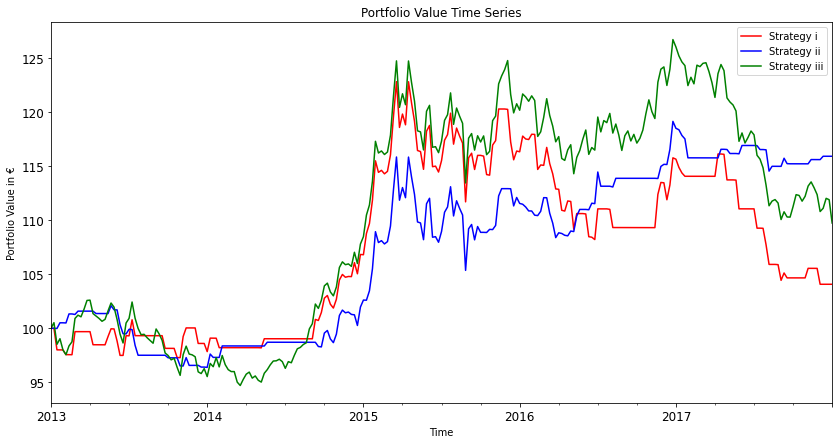

In [5]:
#We plot the development of the budget in euro during the time series for all three strategies
#For this we use the DataFrames copy we used when applying the strategies
week_strategy_i.budget_in_euro.plot(color = ['r'], label = 'Strategy i', figsize = (14,7), fontsize = 12)
week_strategy_ii.budget_in_euro.plot(color = ['b'], label = 'Strategy ii', figsize = (14,7), fontsize = 12)
week_strategy_iii.budget_in_euro.plot(color = ['g'], label = 'Strategy iii', figsize = (14,7), fontsize = 12)
plt.title('Portfolio Value Time Series')
plt.legend()
plt.ylabel('Portfolio Value in €')
plt.xlabel('Time')
plt.show()